# TR-RB simulation

In [ ]:
 # ~~~
 # This file is part of the paper:
 #
 #   "Model Reduction for Large Scale Systems"
 #
 #   https://github.com/TiKeil/Petrov-Galerkin-TR-RB-for-pde-opt
 #
 # Copyright 2019-2021 all developers. All rights reserved.
 # License: Licensed as BSD 2-Clause License (http://opensource.org/licenses/BSD-2-Clause)
 # Authors:
 #   Tim Keil (2019 - 2021)
 # ~~~

# Preparations

## details

In this notebook we discretize the following problem: 
Find $u_{\mu}$ solving the following parametrized constrained equation

\begin{align*}
	-  \nabla \cdot \left( \kappa_{\mu}  \nabla u_{\mu} \right) &= f_{\mu} &&\text{in } \Omega, \\
	q ( \kappa_{\mu}  \nabla u_{\mu} \cdot n) &= (u_{\text{out}} - u_{\mu}) &&\text{on } \partial \Omega.
\end{align*}

For the definition of $\kappa_{\mu}$ and $f_{\mu}$ in the computational domain $\Omega$, we use the `BitmapFunction` from PyMOR. This function uses the Python Imaging Library (PIL) in order to convert a .png grayscale picture to a data function on our domain.
Walls, windows and doors are stored in seperated .png to enable a affine decomposition of each part of the picture. Furthermore, we are considering a heater at each window. The numbering of the components for $\kappa_{\mu}$ can be seen in the following picture
![EXC_notebook_data/EXC_MM_with_numbers.png](../../EXC_notebook_data/Domain_of_interestin_Omega.png)

Here, numbers with | are walls, numbers with _ are doors and numbers with dots are windows

The heaters are numbered in the following way:
![EXC_notebook_data/EXC_MM_with_numbers_heat.png](../../EXC_notebook_data/EXC_MM_with_numbers_heat.png)

For our pde constrained model, we need to define a cost functional. In a general quadratic model, we have 

\begin{align}
\mathcal{J}(u, \mu) := \Theta(\mu) + j_\mu(u) + k_\mu(u, u),
\end{align}

For this code, we restrict ourselves to the following definition
\begin{align}
\mathcal{J}(v, \mu) = \frac{\sigma_d}{2} \int_{D}^{} (v - u^{\text{d}})^2 + \frac{1}{2} \sum^{M}_{i=1} \sigma_i \mu_i^2,
\end{align}
which means

\begin{align}
\Theta(\mu) &= \frac{1}{2} \sum^{M}_{i=1} \sigma_i \mu_i^2 + \frac{\sigma_d}{2} \int_{D}^{} u^{\text{d}} u^{\text{d}}\\
j_{\mu}(u) & = -\sigma_d \int_{D}^{} u^{\text{d}}u \\
k_{\mu}(u,u) &= \frac{\sigma_d}{2} \int_{D}^{} u^2 
\end{align}

The following code implements this particular case.

## prepare cells

In [2]:
import numpy as np

from matplotlib import pyplot as plt

from pymor.basic import *
set_log_levels({'pymor': 'WARN'})
np.warnings.filterwarnings('ignore') # silence numpys warnings

In [3]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'pymor': 'ERROR',
                'distributed_adaptive_discretizations': 'DEBUG',
                'notebook': 'INFO'})
logger = getLogger('notebook.notebook')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300

data_path = '../../../EXC_data'
# domain of interest
bounding_box = [[0,0],[2,1]]
# domain_of_interest = ConstantFunction(1,2)
domain_of_interest = BitmapFunction('{}/Domain_of_interest.png'.format(data_path), range=[1,0], bounding_box=bounding_box)

## problem definition and tolerances

In [4]:
from pdeopt.problems import EXC_problem, set_input_dict
from pdeopt.discretizer import discretize_quadratic_pdeopt_stationary_cg

parametric_quantities = {'walls': [1,4,9], 'windows': [], 'doors': [6,7], 'heaters': [1,3,5,6,7,8,9]}
inactive_quantities = {'removed_walls': [], 'open_windows': [], 'open_doors': [1,2,3,4,5,10], 'active_heaters': []}
summed_quantities = {'walls': [[1,2,3,7,8],[4,5,6]], 'windows': [], 'doors': [], 'heaters': [[1,2],[3,4],[9,10,11,12]]}

coefficient_expressions = None

parameters_in_q = True
input_dict = set_input_dict(parametric_quantities, inactive_quantities, coefficient_expressions, summed_quantities, parameters_in_q,
                            ac=0.5, owc=[0.025,0.1], iwc= [0.025,0.1], idc=[0.05,0.2], wc=[0.0005], ht=[0,100],
                                    owc_c=0.001,  iwc_c= 0.025,     idc_c=0.01,  wc_c=0.05,  ht_c=80)


parameter_scaling = False
u_out = 5

problem, parameter_scales = EXC_problem(input_dict, summed_quantities, outside_temperature=u_out, #, q_inverse=0.0001
                                        data_path = data_path,parameters_in_q=parameters_in_q, 
                                        parameter_scaling=parameter_scaling,
                                        coefficient_expressions=coefficient_expressions)

u_d = 18 

mu_d = problem.parameter_space.sample_randomly(1, seed=10)[0]
mu_d = None

sigma_d = 100
weights = {'walls': 0.1, 'doors': 1, 'heaters': [0.002,0.002,0.0005,0.0005,0.0005,0.0005,0.004], 'windows': 1, 'state': sigma_d}

diameter = np.sqrt(2)/200.
opt_fom, data, mu_bar = discretize_quadratic_pdeopt_stationary_cg(problem, diameter, weights, parameter_scales, 
                                                          domain_of_interest, desired_temperature=u_d, 
                                                          mu_for_u_d=mu_d, mu_for_tikhonov=mu_d,
                                                          parameters_in_q=parameters_in_q, product='fixed_energy')

I am using the NCD corrected functional!!
my product is fixed_energy
mu_bar is: {doors: [0.1, 0.1], heaters: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0], walls: [0.049999999999999996, 0.049999999999999996, 0.049999999999999996]}


In [5]:
print('Information on the grid:')
print(data['grid'])

seed = 7                   # random seed for the starting value
radius = 0.1               # TR radius 
FOC_tolerance = 1e-6       # tau_FOC
sub_tolerance = 1e-8       # tau_sub
safety_tol = 1e-16         # Safeguard, to avoid running the optimizer for really small difference in digits
max_it = 60                # Maximum number of iteration for the TR algorithm
max_it_sub = 400           # Maximum number of iteration for the TR optimization subproblem
max_it_FOM = 800           # Maximum number of iteration for the FOM method
max_it_arm = 50            # Maximum number of iteration for the Armijo rule
init_step_armijo = 0.5     # Initial step for the Armijo rule
armijo_alpha = 1e-4        # kappa_arm
beta = 0.95                # beta_2
epsilon_i = 1e-8           # Treshold for the epsilon active set (Kelley '99)
iterative_solver = 'CG'    # chosen iterative solver for Newton
control_mu = False         # parameter control disabled for this publication

# some implementational variables
Qian_Grepl_subproblem = True
reductor_type = 'simple_coercive'

Information on the grid:
Rect-Grid on domain [0,2] x [0,1]
x0-intervals: 400, x1-intervals: 200
faces: 80000, edges: 160600, vertices: 80601


In [6]:
# starting with 
parameter_space = problem.parameter_space
mu = parameter_space.sample_randomly(1, seed=seed)[0]

### What methods do you want to test ?

In [7]:
optimization_methods = [
    # FOM Method
    'BFGS',
    # BFGS
        # NCD-corrected from KMSOV'20
         'Method_8', # TR-RB
        # PG variant 
        'Method_8_pg', # TR-RB

    'Method_nc'
]

#optimization_methods = ['All']

## Visualizations

Visualize diffusion and rhs

In [8]:
from pymor.discretizers.builtin.cg import InterpolationOperator

vis_mu = mu.copy()
diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(vis_mu)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(vis_mu)
doI = InterpolationOperator(data['grid'], domain_of_interest).as_vector(vis_mu)

opt_fom.visualize(diff)

Output()

In [9]:
opt_fom.visualize(rhs)

Output()

In [10]:
opt_fom.visualize(doI)

Output()

We can easily solve the primal and dual equations by calling 

In [11]:
u = opt_fom.solve(mu)
p = opt_fom.solve_dual(mu)

opt_fom.visualize(u)

Output()

In [12]:
opt_fom.visualize(p)

Output()

# Full Order Optimization

In [13]:
parameters = opt_fom.parameters
if mu_d is not None:
    mu_opt = mu_d
else:
    #use result from previous FOM run
    mu_opt = parameters.parse(np.array([5.000000000000e-02,  5.000000000000e-02,  2.238254711947e+01,
  2.339650455721e+01,  4.870348426512e+01,  4.937422778852e+01,
  5.236272251326e+01,  5.411556305764e+01,  2.352380079299e+01,
  2.500000000000e-02,  2.500000000000e-02,  2.500000000000e-02]))
    
mu_opt_as_array = mu_opt.to_numpy()
J_opt = opt_fom.output_functional_hat(mu_opt)
print('Optimal parameter: ', mu_opt_as_array)
print('Optimal J: ', J_opt)

print()
print('Starting parameter: ', mu.to_numpy())
J_start = opt_fom.output_functional_hat(mu)
print('Starting J: ', J_start)

Optimal parameter:  [5.00000000e-02 5.00000000e-02 2.23825471e+01 2.33965046e+01
 4.87034843e+01 4.93742278e+01 5.23627225e+01 5.41155631e+01
 2.35238008e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02]
Optimal J:  5.813965062384796

Starting parameter:  [6.14462434e-02 1.66987819e-01 4.38409231e+01 7.23465178e+01
 9.77989512e+01 5.38495870e+01 5.01120464e+01 7.20511334e+00
 2.68438980e+01 6.24911876e-02 7.59422497e-02 8.52804277e-02]
Starting J:  142.0522187579113


In [14]:
print(mu_opt.parameters)

{doors: 2, heaters: 7, walls: 3}


## FOM BFGS

In [15]:
from pdeopt.TR import solve_optimization_subproblem_BFGS
from pdeopt.tools import compute_errors

TR_parameters = {'radius': 1.e18, 'sub_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': max_it_FOM,
                 'starting_parameter': mu,
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True}

if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    muoptfom,_,_,_, times_FOM, mus_FOM, Js_FOM, FOC_FOM = solve_optimization_subproblem_BFGS(opt_fom, problem.parameter_space,mu, TR_parameters, timing=True, FOM=True)
    times_full_FOM, J_error_FOM, mu_error_FOM, FOC = compute_errors(opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, 
                                               mus_FOM, Js_FOM, times_FOM, 0, FOC_FOM)
    times_full_FOM = times_full_FOM[1:]

Starting projected BFGS method
Starting parameter {doors: [0.06144624340609358, 0.1669878188360172], heaters: [43.84092314408935, 72.34651778309413, 97.79895119966027, 53.849587041043364, 50.11204636599379, 7.205113335976154, 26.843898010187118], walls: [0.062491187561917, 0.07594224970907054, 0.08528042770782818]}
Step [5.00000000e-02 5.00000000e-02 4.04243253e+01 6.87313568e+01
 9.59496780e+01 5.19984998e+01 4.81439933e+01 5.20686729e+00
 1.97830458e+01 2.50000000e-02 2.50000000e-02 1.00000000e-01], functional 66.66395457794351 , FOC condition 6.204602119575381
Step [5.00000000e-02 5.00000000e-02 2.74877741e+01 5.50341275e+01
 8.89434382e+01 4.49871172e+01 4.06862995e+01 0.00000000e+00
 0.00000000e+00 2.50000000e-02 2.50000000e-02 1.00000000e-01], functional 31.164474811840364 , FOC condition 3.8807810328761496
Step [2.00000000e-01 2.00000000e-01 4.10836312e+01 6.94046003e+01
 9.63044618e+01 5.23664480e+01 4.85419050e+01 4.34467154e-01
 1.48232482e+00 1.00000000e-01 1.00000000e-01 2.

Step [5.00000000e-02 5.00000000e-02 3.08231678e+01 1.78208946e+01
 7.12250802e+01 4.69376165e+01 4.60965834e+01 3.16335310e+01
 2.53996020e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 6.195805083656978 , FOC condition 0.028847264498714095
Step [5.00000000e-02 5.00000000e-02 3.06738778e+01 1.81700799e+01
 7.13312163e+01 4.69094675e+01 4.60438415e+01 3.14414939e+01
 2.54445712e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 6.193203592824375 , FOC condition 0.029267585734667333
Step [5.00000000e-02 5.00000000e-02 3.07786194e+01 1.75832739e+01
 7.08373667e+01 4.70528228e+01 4.63038246e+01 3.22340157e+01
 2.51502749e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 6.191421242616116 , FOC condition 0.0727460664813693
Step [5.00000000e-02 5.00000000e-02 3.03413580e+01 1.87916834e+01
 7.14155314e+01 4.68849073e+01 4.59990559e+01 3.12621708e+01
 2.55352059e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 6.1901128445922495 , FOC conditio

Step [5.00000000e-02 5.00000000e-02 2.68227028e+01 1.89334616e+01
 6.47550645e+01 4.87715462e+01 4.94412146e+01 4.15175073e+01
 2.40167467e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.964649438173183 , FOC condition 0.03808150947420813
Step [5.00000000e-02 5.00000000e-02 2.68510345e+01 1.90926963e+01
 6.47496390e+01 4.88242718e+01 4.95065574e+01 4.16196168e+01
 2.41955541e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.964603462746027 , FOC condition 0.051864163147851354
Step [5.00000000e-02 5.00000000e-02 2.67796264e+01 1.90470685e+01
 6.47060414e+01 4.87931910e+01 4.94751635e+01 4.15948958e+01
 2.40712616e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.960600421817617 , FOC condition 0.017123331669557765
Step [5.00000000e-02 5.00000000e-02 2.66168530e+01 1.93677754e+01
 6.45381762e+01 4.88439101e+01 4.95627810e+01 4.18164017e+01
 2.41776531e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.958391922983765 , FOC conditio

Step [5.00000000e-02 5.00000000e-02 2.10358081e+01 2.53609575e+01
 5.95388078e+01 4.91543546e+01 5.07034413e+01 4.61821449e+01
 2.32457582e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.866644959023915 , FOC condition 0.008705337762876481
Step [5.00000000e-02 5.00000000e-02 2.09541779e+01 2.54312434e+01
 5.94656819e+01 4.91541135e+01 5.07142569e+01 4.62370769e+01
 2.32167895e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.866595353145158 , FOC condition 0.010619186375150325
Step [5.00000000e-02 5.00000000e-02 2.09560359e+01 2.54505140e+01
 5.94624835e+01 4.91601947e+01 5.07221761e+01 4.62507846e+01
 2.32369209e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.866532870955098 , FOC condition 0.009154935494248957
Step [5.00000000e-02 5.00000000e-02 2.09183330e+01 2.54781690e+01
 5.94292150e+01 4.91587253e+01 5.07254310e+01 4.62732446e+01
 2.32191863e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.866490799071926 , FOC conditi

Step [5.00000000e-02 5.00000000e-02 2.06347394e+01 2.53634626e+01
 5.73726556e+01 4.91809329e+01 5.10539349e+01 4.78477327e+01
 2.31835245e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.854888253149511 , FOC condition 0.05328956135084718
Step [5.00000000e-02 5.00000000e-02 2.09102834e+01 2.52487130e+01
 5.74775581e+01 4.92250567e+01 5.10912615e+01 4.78487133e+01
 2.34195203e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.85186361120418 , FOC condition 0.038406613457261964
Step [5.00000000e-02 5.00000000e-02 2.07248407e+01 2.52324234e+01
 5.70055830e+01 4.91967131e+01 5.11262804e+01 4.81490909e+01
 2.32629238e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.849001300906139 , FOC condition 0.034589997887428905
Step [5.00000000e-02 5.00000000e-02 2.09048984e+01 2.51338187e+01
 5.69754733e+01 4.92256985e+01 5.11652327e+01 4.82233896e+01
 2.34170895e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.846685644749641 , FOC condition

Step [5.00000000e-02 5.00000000e-02 2.15986839e+01 2.29239860e+01
 4.93145029e+01 4.93390140e+01 5.24161675e+01 5.41227705e+01
 2.39639741e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.815285317598864 , FOC condition 0.002520174707695076
Step [5.00000000e-02 5.00000000e-02 2.15999963e+01 2.29124381e+01
 4.92641207e+01 4.93388363e+01 5.24231905e+01 5.41596241e+01
 2.39610345e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.815283849364278 , FOC condition 0.0031849380141379968
Step [5.00000000e-02 5.00000000e-02 2.16061183e+01 2.29134321e+01
 4.92808708e+01 4.93397517e+01 5.24218314e+01 5.41487777e+01
 2.39659296e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8152776651161275 , FOC condition 0.002547502531318011
Step [5.00000000e-02 5.00000000e-02 2.16042767e+01 2.29088381e+01
 4.92531346e+01 4.93392703e+01 5.24252298e+01 5.41683479e+01
 2.39618913e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.815276926036404 , FOC condi

Step [5.00000000e-02 5.00000000e-02 2.21377148e+01 2.31934495e+01
 4.90330733e+01 4.93776851e+01 5.24761697e+01 5.43233904e+01
 2.35779598e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814139320063759 , FOC condition 0.0040499675590589855
Step [5.00000000e-02 5.00000000e-02 2.21338782e+01 2.31941146e+01
 4.89924316e+01 4.93764635e+01 5.24802576e+01 5.43503451e+01
 2.35629842e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814110481375565 , FOC condition 0.0009069043478887583
Step [5.00000000e-02 5.00000000e-02 2.21841564e+01 2.32220046e+01
 4.90134796e+01 4.93807183e+01 5.24801014e+01 5.43360959e+01
 2.35393781e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8140961265139595 , FOC condition 0.0035454094106809955
Step [5.00000000e-02 5.00000000e-02 2.21795014e+01 2.32218264e+01
 4.89782415e+01 4.93795478e+01 5.24835740e+01 5.43594429e+01
 2.35271789e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814075562224389 , FOC con

Step [5.00000000e-02 5.00000000e-02 2.23070865e+01 2.32992759e+01
 4.89599674e+01 4.93871991e+01 5.24880861e+01 5.43659160e+01
 2.34314217e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8140350928722455 , FOC condition 0.00045953708035064415
Step [5.00000000e-02 5.00000000e-02 2.23060295e+01 2.32988781e+01
 4.89570703e+01 4.93870299e+01 5.24882960e+01 5.43677399e+01
 2.34309089e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814034924166208 , FOC condition 0.0003581861756023444
Step [5.00000000e-02 5.00000000e-02 2.23089460e+01 2.33004659e+01
 4.89610098e+01 4.93870456e+01 5.24873840e+01 5.43638421e+01
 2.34312104e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.81403484587986 , FOC condition 0.0005847034100193317
Step [5.00000000e-02 5.00000000e-02 2.23071451e+01 2.32997608e+01
 4.89563499e+01 4.93867741e+01 5.24877322e+01 5.43668049e+01
 2.34304661e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814034461790243 , FOC con

Step [5.00000000e-02 5.00000000e-02 2.23700203e+01 2.33784235e+01
 4.87859318e+01 4.93266465e+01 5.23724549e+01 5.41961025e+01
 2.35057467e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813970673620133 , FOC condition 0.00051481221728257
Step [5.00000000e-02 5.00000000e-02 2.23678243e+01 2.33784416e+01
 4.87748449e+01 4.93251696e+01 5.23711464e+01 5.41984815e+01
 2.35058835e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813970161712405 , FOC condition 0.00045792009284459405
Step [5.00000000e-02 5.00000000e-02 2.23717381e+01 2.33814966e+01
 4.87754568e+01 4.93238154e+01 5.23675354e+01 5.41903076e+01
 2.35087971e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813969366791525 , FOC condition 0.0002389374528050992
Step [5.00000000e-02 5.00000000e-02 2.23734721e+01 2.33872527e+01
 4.87483147e+01 4.93175434e+01 5.23574940e+01 5.41811858e+01
 2.35145502e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813969092176194 , FOC condi

Step [5.00000000e-02 5.00000000e-02 2.23863754e+01 2.34007216e+01
 4.87270323e+01 4.93090690e+01 5.23397673e+01 5.41520483e+01
 2.35267732e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.81396679596719 , FOC condition 4.829952743326364e-05
Step [5.00000000e-02 5.00000000e-02 2.23862524e+01 2.34006445e+01
 4.87268864e+01 4.93090946e+01 5.23398484e+01 5.41522829e+01
 2.35266985e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813966794798034 , FOC condition 4.299458789431534e-05
Step [5.00000000e-02 5.00000000e-02 2.23865601e+01 2.34009011e+01
 4.87267377e+01 4.93090340e+01 5.23395706e+01 5.41516445e+01
 2.35269186e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8139667940370146 , FOC condition 5.764250851041304e-05
Step [5.00000000e-02 5.00000000e-02 2.23863380e+01 2.34007549e+01
 4.87265269e+01 4.93090839e+01 5.23397264e+01 5.41520715e+01
 2.35267798e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813966791209168 , FOC cond

Step [5.00000000e-02 5.00000000e-02 2.23838204e+01 2.33979612e+01
 4.87104412e+01 4.93547286e+01 5.23555932e+01 5.41251919e+01
 2.35251170e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965215474809 , FOC condition 3.723439794453205e-05
Step [5.00000000e-02 5.00000000e-02 2.23828381e+01 2.33971890e+01
 4.87086298e+01 4.93585411e+01 5.23574671e+01 5.41246587e+01
 2.35244507e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.81396518291308 , FOC condition 0.00011984165667226974
Step [5.00000000e-02 5.00000000e-02 2.23834882e+01 2.33976018e+01
 4.87088377e+01 4.93593857e+01 5.23573163e+01 5.41227339e+01
 2.35248497e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.81396515073925 , FOC condition 2.895089250187927e-05
Step [5.00000000e-02 5.00000000e-02 2.23827211e+01 2.33969915e+01
 4.87073510e+01 4.93625690e+01 5.23588537e+01 5.41222032e+01
 2.35243178e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.81396512932406 , FOC condit

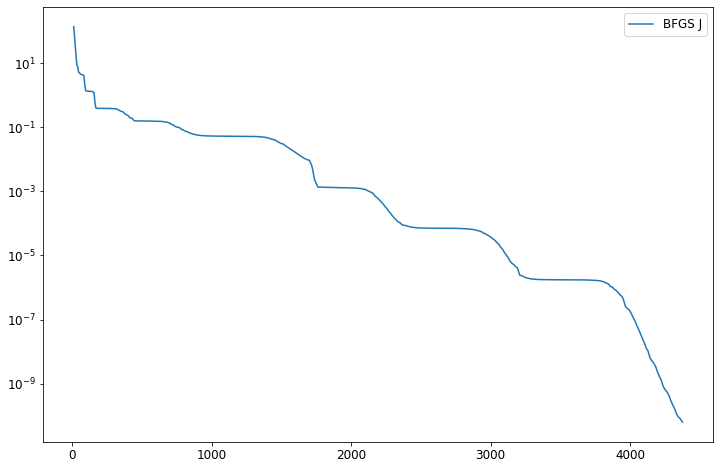

In [16]:
if 'BFGS' in optimization_methods or 'BFGS' in optimization_methods:
    plt.semilogy(times_full_FOM,J_error_FOM, label='BFGS J')
    plt.legend()

# TR-RB approaches

In [19]:
import time
from pdeopt.model import build_initial_basis
from pdeopt.reductor import QuadraticPdeoptStationaryCoerciveReductor
from pdeopt.TR import TR_algorithm

from pymor.parameters.functionals import MinThetaParameterFunctional
ce = MinThetaParameterFunctional(opt_fom.primal_model.operator.coefficients, mu_bar)

set_defaults({'pymor.operators.constructions.induced_norm.raise_negative': False})
set_defaults({'pymor.operators.constructions.induced_norm.tol': 1e-20})

## NCD corrected BFGS Method (KMSOV'20)

In [28]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_8' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}

    mus_8, times_8, Js_8, FOC_8, data_8 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_8_actual, J_error_8_actual, mu_error_8_actual, FOC_8_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_8, Js_8, times_8, tictoc, FOC_8)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.06144624340609358, 0.1669878188360172], heaters: [43.84092314408935, 72.34651778309413, 97.79895119966027, 53.849587041043364, 50.11204636599379, 7.205113335976154, 26.843898010187118], walls: [0.062491187561917, 0.07594224970907054, 0.08528042770782818]}
Starting value of the cost: 142.05221870501896
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of bases are 2 and 2
k: 0 - j 2 - Cost Functional: 114.4540735118353 - mu: {doors: [0.05, 0.057542402967186886], heaters: [42.78954241131653, 71.23303262313476, 97.22952227306698, 53.27985164

boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of bases are 11 and 11
k: 9 - j 9 - Cost Functional: 6.466350752201869 - mu: {doors: [0.05, 0.05], heaters: [23.38901502087909, 27.29361470762578, 78.07268791916628, 47.874888427006255, 46.07542001005001, 17.242478445682856, 25.797309117811434], walls: [0.025, 0.1, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 0.1627246698276972
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting enrichment
building simple coercive dual reductor...
Enrichment completed... length of bases are 12 and 12
k: 10 - j 9 - Cost Functional: 5.978030952491309 - mu: {doors: [0.05,

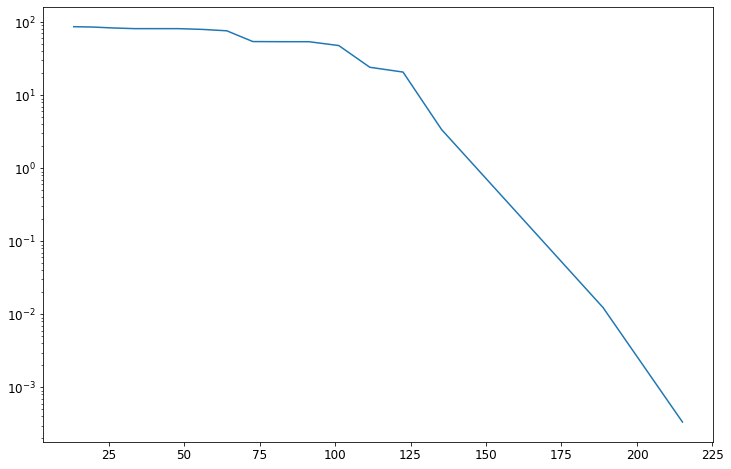

In [29]:
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,mu_error_8_actual)

## Petrov-Galerkin approach

### BFGS

In [30]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
opt_fom_pg = opt_fom.with_(petrov_galerkin=True) 

from pdeopt.pg_reductor import QuadraticPdeoptStationaryCoercivePGReductor

if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoercivePGReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                reductor_type=reductor_type, mu_bar=mu_bar,
                                                least_squares=True)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}

    mus_8_pg, times_8_pg, Js_8_pg, FOC_8_pg, data_8_pg = TR_algorithm(opt_rom, pdeopt_reductor,
                                                                      parameter_space, 
                                                                      TR_parameters, extension_params)
    
    times_full_8_pg_actual, J_error_8_pg_actual, mu_error_8_pg_actual, FOC_8_pg_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_8_pg, Js_8_pg, times_8_pg, tictoc, FOC_8_pg)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.06144624340609358, 0.1669878188360172], heaters: [43.84092314408935, 72.34651778309413, 97.79895119966027, 53.849587041043364, 50.11204636599379, 7.205113335976154, 26.843898010187118], walls: [0.062491187561917, 0.07594224970907054, 0.08528042770782818]}
Starting value of the cost: 142.0522187050192
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of Bases are 2 and 2
k: 0 - j 2 - Cost Functional: 113.22448668213246 - mu: {doors: [0.05, 0.05215858574911851], heaters: [42.73668247040834, 71.17731602934013, 97.20112823183449, 53.251510923

boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of Bases are 13 and 13
k: 11 - j 4 - Cost Functional: 6.649802512332144 - mu: {doors: [0.05, 0.05], heaters: [21.72650225383712, 26.87560490627698, 81.24063859782771, 46.93977530974269, 44.369805417243256, 11.355205817307969, 28.998259322654647], walls: [0.08671532017262998, 0.09967825187663541, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 0.041125576832439587
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: -0.00021344846022975367
Reset direction to - gradient
Curvature condition: -0.00010792747352085564
Reset direction to - gradient
Curvature condition: -7.909517838503874e-05
Reset direction to - gradient
Curvature condition: -1.044429105

building simple coercive dual reductor...
Enrichment completed... length of Bases are 23 and 23
k: 21 - j 10 - Cost Functional: 5.8139650630735105 - mu: {doors: [0.05, 0.05], heaters: [22.382342041060188, 23.396690848863976, 48.70361654156394, 49.37394050064218, 52.362992687880585, 54.11562212615849, 23.52375163329861], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 7.946193617396531e-07
******************************* 


Stopping criteria fulfilled: FOC condition: 7.946193617396531e-07
Computing only the initial FOC


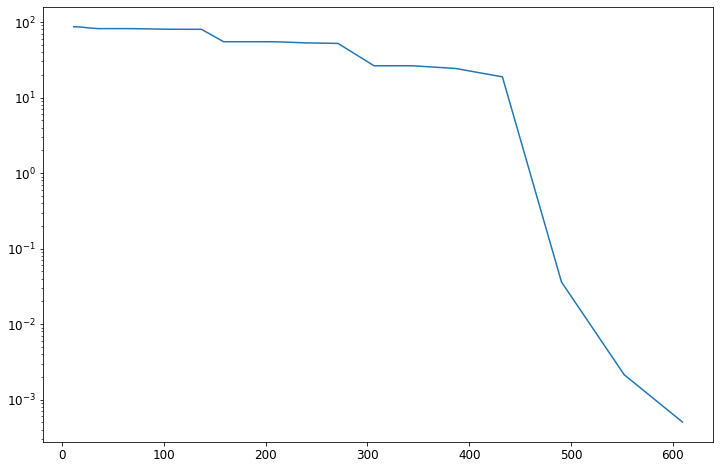

In [31]:
if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_pg_actual,mu_error_8_pg_actual)

## Non corrected approach

In [36]:
tic = time.time()
params = [mu]

opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
opt_fom = opt_fom.with_(petrov_galerkin=False)

if 'Method_nc' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom_pg, params, build_sensitivities=False)


    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                                RBbasis, dual_RBbasis, 
                                                                opt_product=opt_fom.opt_product,
                                                                coercivity_estimator=ce,
                                                                mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = { 'Qian-Grepl_subproblem': Qian_Grepl_subproblem,  'beta': beta,
                     'safety_tolerance': safety_tol,
                     'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                     'sub_tolerance': sub_tolerance,
                     'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                     'max_iterations_armijo': max_it_arm,
                     'initial_step_armijo': init_step_armijo, 
                     'armijo_alpha': armijo_alpha, 
                     'epsilon_i': epsilon_i, 
                     'starting_parameter': mu,
                     'control_mu': control_mu,
                     'opt_method': 'BFGSMethod'}

    extension_params = {"Enlarge_radius": True, 'timings': True}

    mus_nc, times_nc, Js_nc, FOC_nc = TR_algorithm(
        opt_rom, pdeopt_reductor, parameter_space, TR_parameters, extension_params)

    times_full_nc_actual, J_error_nc_actual, mu_error_nc_actual, FOC_nc_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_nc, Js_nc, times_nc, tictoc, FOC_nc)


Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.06144624340609358, 0.1669878188360172], heaters: [43.84092314408935, 72.34651778309413, 97.79895119966027, 53.849587041043364, 50.11204636599379, 7.205113335976154, 26.843898010187118], walls: [0.062491187561917, 0.07594224970907054, 0.08528042770782818]}
Starting value of the cost: 142.0522187058109
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of bases are 2 and 2
k: 0 - j 1 - Cost Functional: 119.10600954510983 - mu: {doors: [0.05, 0.06623758329581342], heaters: [42.98677368551933, 71.44272753225131, 97.33663289674608, 53.386815224

enlarging the TR radius to 25.6
k: 9 - j 13 - Cost Functional: 5.8139633493440215 - mu: {doors: [0.05, 0.05], heaters: [22.3777351433962, 23.363075522301887, 48.783521264663534, 49.34125878214283, 52.3286541118639, 54.027033863713115, 23.565458734939423], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 0.00021719680519696416
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Subproblem converged: FOC = 5.973921012255743e-05, mu_diff = 5.645560857892099e-14, J_diff = 0.0 
relative differences mu 5.645560857892099e-14 and J 0.0
checked sufficient condition, starting enrichment
building simple coercive dual reductor...
Enrichment completed... length of bases are 12 and 12
enlarging the TR radius to 51.2
k: 10 - j 40 - Cost Functional: 5.813969595319577 - mu: {doors: [0.05, 0.05], heaters: [22.392476380634164, 23.399036413164314, 48.775147034874

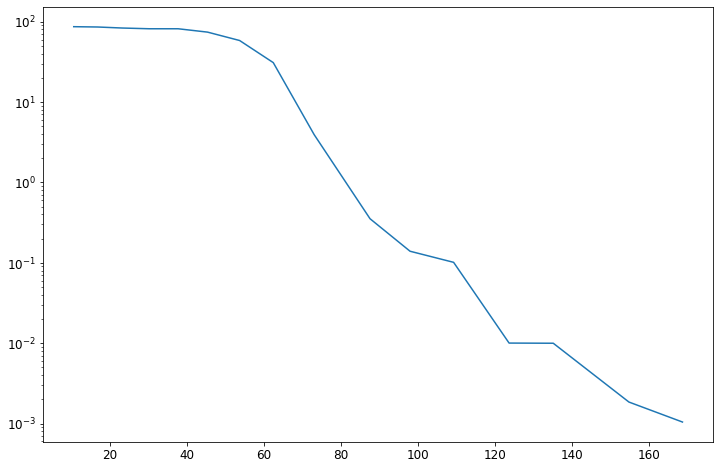

In [37]:
if 'Method_nc' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_nc_actual,mu_error_nc_actual)

# Results

In [38]:
u = opt_fom.solve(mu_opt)
opt_fom.visualize(u)

Output()

## Plot results

### J error

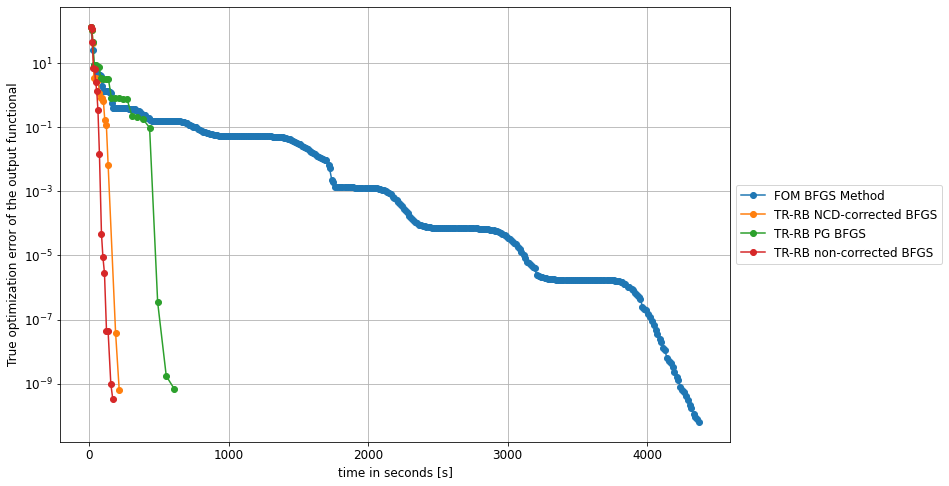

In [39]:
timings_figure = plt.figure()
if 'SH' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH,J_error_SH,'o-', label='FOM SH Method')
if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_FOM,J_error_FOM,'o-', label='FOM BFGS Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual,J_error_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_4_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_pg_actual,J_error_4_pg_actual,'o-', label='4. PG Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual,J_error_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_5_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_pg_actual,J_error_5_pg_actual,'o-', label='5. PG Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual,J_error_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag. optional')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual,J_error_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay. optional')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual,J_error_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual,J_error_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,J_error_8_actual,'o-', label='TR-RB NCD-corrected BFGS')
if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_pg_actual,J_error_8_pg_actual,'o-', label='TR-RB PG BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual,J_error_9_actual,'o-', label='9. Qian-Grepl')
if 'Method_nc' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_nc_actual, J_error_nc_actual,'o-', label='TR-RB non-corrected BFGS')

    
plt.xlabel('time in seconds [s]')
plt.ylabel('True optimization error of the output functional')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Plot FOC

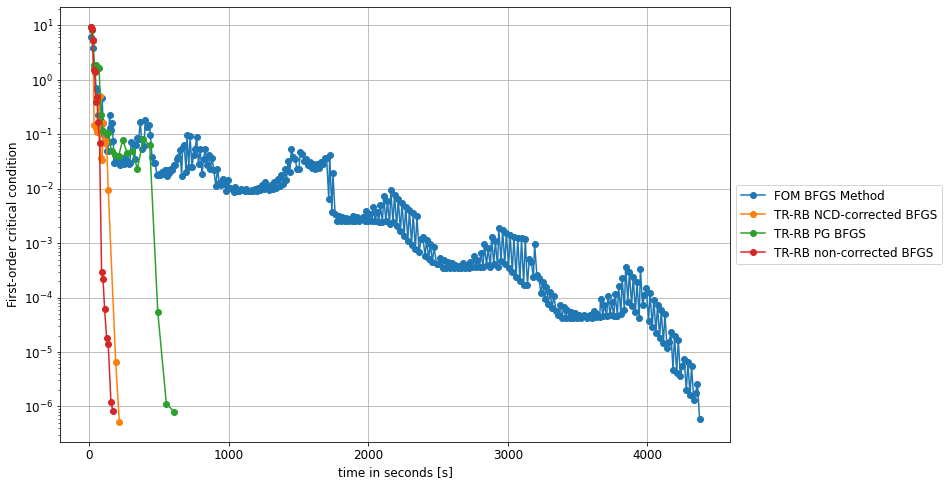

In [40]:
timings_figure = plt.figure()

if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH, FOC_SH,'o-', label='FOM Method')
if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_FOM, FOC_FOM,'o-', label='FOM BFGS Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual, FOC_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_4_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_pg_actual,FOC_4_pg_actual,'o-', label='4. PG Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual, FOC_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_5_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_pg_actual,FOC_5_pg_actual,'o-', label='5. PG Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual, FOC_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag.')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual, FOC_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay.')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual, FOC_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual, FOC_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual, FOC_8_actual,'o-', label='TR-RB NCD-corrected BFGS')
if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_pg_actual,FOC_8_pg_actual,'o-', label='TR-RB PG BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual, FOC_9_actual,'o-', label='9. Qian-Grepl')
if 'Method_nc' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_nc_actual, FOC_nc_actual,'o-', label='TR-RB non-corrected BFGS')

    
plt.xlabel('time in seconds [s]')
plt.ylabel('First-order critical condition')
# plt.xlim([-1,30])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Plot Mu error

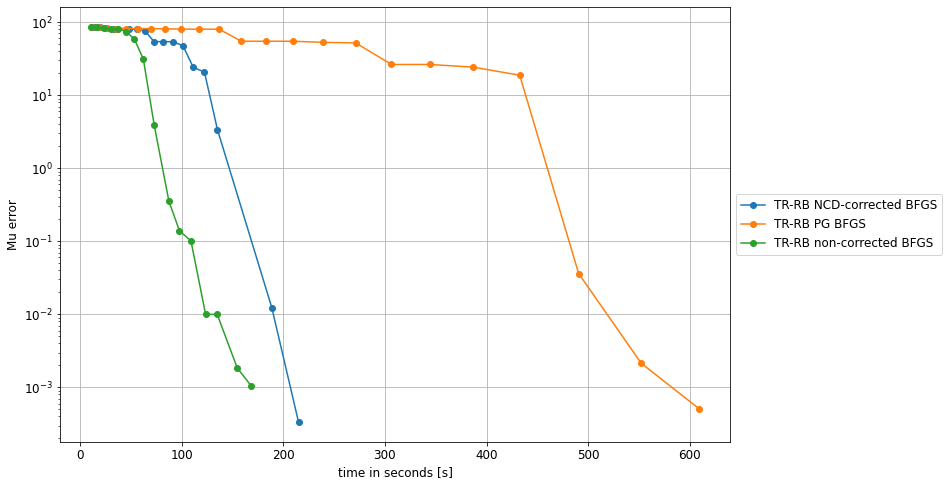

In [41]:
# if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
#     plt.semilogy(times_full_SH, mu_error_SH,'o-', label='FOM Method')
# if 'BFGS' in optimization_methods or 'All' in optimization_methods:
#     plt.semilogy(times_full_FOM, mu_error_FOM,'o-', label='FOM BFGS Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual,mu_error_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_4_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_pg_actual,mu_error_4_pg_actual,'o-', label='4. PG Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual,mu_error_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_5_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_pg_actual,mu_error_5_pg_actual,'o-', label='5. PG Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual,mu_error_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag.')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual,mu_error_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay.')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual,mu_error_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual,mu_error_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,mu_error_8_actual,'o-', label='TR-RB NCD-corrected BFGS')
if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_pg_actual,mu_error_8_pg_actual,'o-', label='TR-RB PG BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual,mu_error_9_actual,'o-', label='9. Qian-Grepl')
if 'Method_nc' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_nc_actual, mu_error_nc_actual,'o-', label='TR-RB non-corrected BFGS')

    
plt.xlabel('time in seconds [s]')
plt.ylabel('Mu error')
#plt.xlim([-1,100])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Save the data

In [42]:
#save data
from pdeopt.tools import save_data

directory = f'results/Starter{seed}'

if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_SH, J_error_SH, 1, mu_error=mu_error_SH, FOC=FOC_SH)
if 'BFGS' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_FOM, J_error_FOM, 1, mu_error=mu_error_FOM, FOC=FOC_FOM)
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_4_actual, J_error_4_actual, 4, mu_error=mu_error_4_actual, FOC=FOC_4_actual, additional_data=data_4)
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_5_actual, J_error_5_actual, 5, mu_error=mu_error_5_actual, FOC=FOC_5_actual, additional_data=data_5)
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_4bis_actual, J_error_4bis_actual, 2, mu_error=mu_error_4bis_actual, FOC=FOC_4bis_actual, additional_data=data_4bis)
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_5bis_actual, J_error_5bis_actual, 3, mu_error=mu_error_5bis_actual, FOC=FOC_5bis_actual, additional_data=data_5bis)
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_6_actual, J_error_6_actual, 6, mu_error=mu_error_6_actual, FOC=FOC_6_actual, additional_data=data_6)
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_7_actual, J_error_7_actual, 7, mu_error=mu_error_7_actual, FOC=FOC_7_actual, additional_data=data_7)
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_8_actual, J_error_8_actual, 8, mu_error=mu_error_8_actual, FOC=FOC_8_actual, additional_data=data_8)
if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_8_pg_actual, J_error_8_pg_actual, 10, mu_error=mu_error_8_pg_actual, FOC=FOC_8_pg_actual, additional_data=data_8_pg)
if 'Method_nc' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_nc_actual, J_error_nc_actual, 11, mu_error=mu_error_nc_actual, FOC=FOC_nc_actual)
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_9_actual, J_error_9_actual, 9, mu_error=mu_error_9_actual, FOC=FOC_9_actual, additional_data=data_9)    